In [1]:
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from tensorflow.keras import backend as K

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import pickle

import logging
tf.get_logger().setLevel(logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import sys
sys.path.append("../../../libraries/")
import utils

2025-02-22 13:32:26.962415: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-22 13:32:27.000284: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-22 13:32:27.000922: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-22 13:32:27.580113: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Hyperparameters

In [2]:
seeds = [20, 30, 45, 70]

n_categorical_features = 3
n_numerical_features = 5
n_static_features = n_categorical_features + n_numerical_features
n_dynamic_features = 56
n_timesteps = 14

# Hyperparamas of network
balance = True
epochs = 10000
batch_size = 128
num_heads = 1


layers = [3, 5, 8, 10, 15, 20, 25, 30, 35, 40, 50]
lr_scheduler = [0.0001, 0.001, 0.01, 0.1]
dropout_rate = [0.0, 0.1, 0.2, 0.3]

w2 = 0.18
w1 = 0.82

tensor = True
debug = True

hyperparameters = {
    "n_categorical_features": n_categorical_features,
    "n_numerical_features": n_numerical_features,
    "n_static_features": n_static_features,
    "n_dynamic_features": n_dynamic_features,
    "n_timesteps": n_timesteps,
    "num_heads": num_heads,
    "w1":w1, "w2":w2, 

    "epochs":epochs,
    'batch_size': batch_size,
    'maskValue':666,
    'monitor': 'val_loss', 
    "mindelta": 0,
    "patience":30,
    'balance': balance,
    'optimizer':'adam',
    'kfold':5,
    'level':3, 
    'verbose':0
}

# Permutation

In [3]:
from tensorflow.keras.models import load_model

def load_keras_model(filepath):
    custom_loss = utils.weighted_binary_crossentropy(hyperparameters)
    return load_model(filepath, custom_objects={'loss': custom_loss})

def load_predictions(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)

In [4]:
def permutation_time_series(X, k, hyperparameters, seed=None):
    v_feature = X[:, :, k].copy()
    stay_length_array = (v_feature == hyperparameters["maskValue"]).sum(axis=1)
    # Only permute the patient with the same length of stay
    for i in range(v_feature.shape[1]):
        v_feature_masked = v_feature[stay_length_array == i]
        # Set random seed for reproducibility
        np.random.seed(seed)  # Set the seed before shuffling
        np.random.shuffle(v_feature_masked)
        v_feature[stay_length_array == i] = v_feature_masked
    X[:, :, k] = v_feature
    return X

In [5]:
features = ['Age', 'Gender', 'SAPSIIIScore', 'MonthOfAdmission', 'YearOfAdmission',
 'Origin', 'ReasonAdmission', 'PatientCategory']

2025-02-22 13:32:28.810288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-22 13:32:28.832826: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


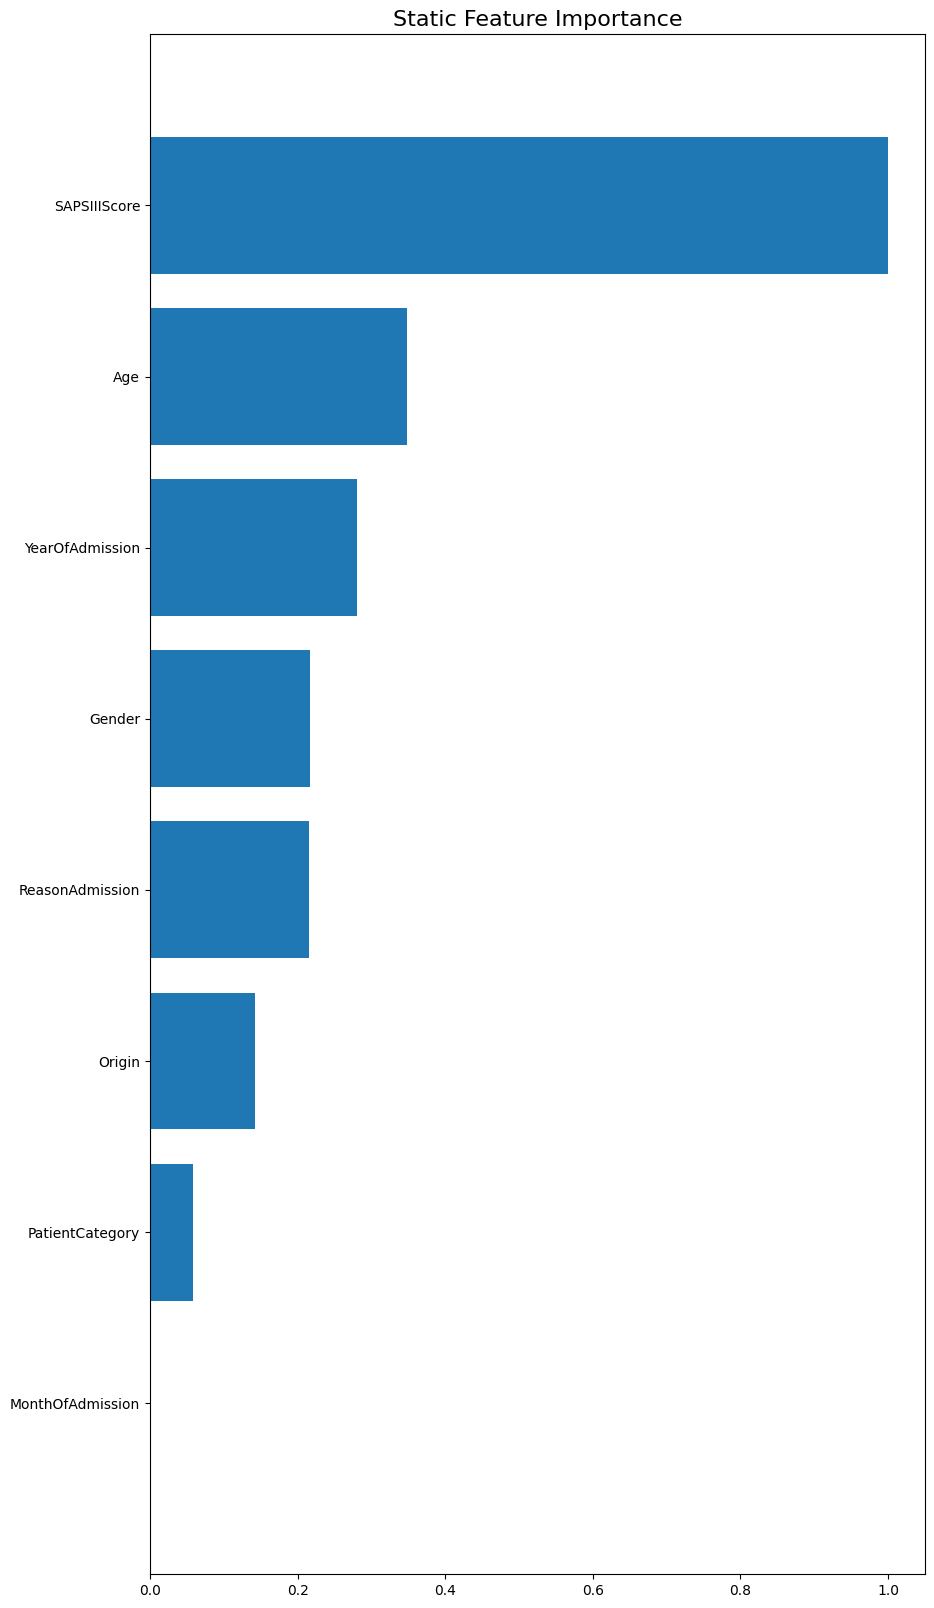

In [6]:
n = 4
results_perm_stat = []
seed_value = 20


for i in [0]:
    results_perm_stat = []
    for k in range(len(features)):
        # Load datasets
        X_train = pd.read_csv("../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_" + str(i) + "/X_train_static_" + str(n)+ ".csv", index_col=0)
        y_train = pd.read_csv("../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_" + str(i) + "/y_train_" + str(n)+ ".csv", index_col=0)
        X_val = pd.read_csv("../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_" + str(i) + "/X_val_static_" + str(n)+ ".csv", index_col=0).values
        y_val = pd.read_csv("../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_" + str(i) + "/y_val_" + str(n)+ ".csv", index_col=0)
        X_test = pd.read_csv("../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_" + str(i) + "/X_test_static.csv", index_col=0)
        y_test = pd.read_csv("../../../ORIGINAL_DATA/MDR/splits_14_days/notbalanced/split_" + str(i) + "/y_test.csv", index_col=0)
        
        # Load model and predictions
        directory = f'../../../experiments/MDR/considering_all_features/Results_MLP/split_{i}' 
        model = load_keras_model(os.path.join(directory, f"model_split_{i}.h5"))
        y_pred = load_predictions(os.path.join(directory, f"y_pred_split_{i}.pkl"))
        roc_baseline = sklearn.metrics.roc_auc_score(y_test.individualMRGerm.values, y_pred)
        
        # Shuffle feature K
        save_col = X_val[:, k].copy()
        np.random.seed(seed_value)  # Set seed for reproducibility
        np.random.shuffle(X_val[:, k])

        # Compute ROC with feature K shuffled
        y_pred = model.predict(X_val, verbose=0) 
        roc = sklearn.metrics.roc_auc_score(y_val.individualMRGerm.values, y_pred)
        results_perm_stat.append(roc_baseline - roc)
        X_val[:, k] = save_col

    # Display feature importance results
    print()
    if i == 0:
        df = pd.DataFrame()
    df["roc_seed_" + str(i)] = results_perm_stat
    df["features"] = features
    df = df.set_index("features")

path = f'./Results_MLP/split_{i}'
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_importance = scaler.fit_transform(df.mean(axis=1).sort_values().values.reshape(-1, 1)).flatten()

plt.figure(figsize=(10, 20))
plt.barh(np.arange(len(features)), normalized_importance)
plt.yticks(np.arange(len(features)), df.mean(axis=1).sort_values().index.values)

plt.title('Static Feature Importance', size=16)
plt.ylim((-1, len(features)))
output_path = os.path.join(path, "static_feature_importance.pdf")
plt.savefig(output_path, format='pdf', bbox_inches='tight')
plt.show()
print()


In [7]:
df["mean_importance"] = df.mean(axis=1)

df.to_csv('./Results_MLP/PFI_MLP.csv')

top_features = df["mean_importance"].nlargest(5).index.tolist()
print("5 best features:", top_features)

mlp_features = pd.DataFrame(top_features, columns=['Selected Feature'])
mlp_features.to_csv('../Results/MLP_selected_features.csv', index=False)



5 best features: ['SAPSIIIScore', 'Age', 'YearOfAdmission', 'Gender', 'ReasonAdmission']
